In [15]:
import numpy as np
import numba
import random
import matplotlib.pyplot as plt
import scipy.integrate

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

## Master equation

While it is useful to demonstrate this behavior stochastically as we've done above, we may also wish to know the deterministic behavior, akin to when we've done numerical integration in for differential equations. For this, we will introduce something known as the "Master Equation" as a way to track not individual particles, but instead the *probability* that particles will be found at various positions. 

This involves keeping track of the probability $p(n,t)$ of particles being at location $n$ at time $t$:

$$
\overbrace{p(n, t+\Delta t)}^{\text {new probability }}=\underbrace{p(n, t)}_{\text {old probability }}+\overbrace{k \Delta t p(n-1, t)}^{\text {particles moving in from left }}+\underbrace{k \Delta t p(n+1, t)}_{\text {particles moving in from right }}-\overbrace{2 k \Delta t p(n, t)}^{\text {particles leaving to left or right }} .
$$

This master equation allows us to calculate the probability of the walker being at position  n  at the next time step  $t+ \Delta t$ , given the probabilities at the current time step  $t$ . $k$  is the "hopping rate" between neighboring positions, and  $\Delta t$  is the time step used in the numerical calculation. For this simulation, we will use a 2D-array where we are keeping track of $N$ "boxes" that the particles can be in over time.

Due computational limits, there are only so many "boxes" we can keep track of. This means we will have to specify what are known as "boundary conditions" at our left-most and right-most boxes.  

### Activity 3

Below specify what the Master Equation would be for the 0th and Nth boxes, keeping in mind that particles :

$$
\overbrace{p(0, t+\Delta t)}^{\text {new probability }}=\underbrace{p(0, t)}_{\text {old probability }} + \overbrace{k \Delta t p(1, t)}_{\text {particles moving in from right }}-\underbrace{k \Delta t p(0, t)}^{\text {particles leaving to the right }} 
$$

$$
\overbrace{p(N, t+\Delta t)}^{\text {new probability }}=\underbrace{p(N, t)}_{\text {old probability }} + \overbrace{k \Delta t p(N-1, t)}_{\text {particles moving in from left }}-\underbrace{k \Delta t p(N, t)}^{\text {particles leaving to the left }} 
$$

Below I set up the parameters and arrays we will need for the Master Equation integration. 

In [2]:
# number of boxes
n_boxes = 41

# time increment (Delta t) in seconds
dt = 0.1

# number of steps
n_steps = 1000

# hopping rate constant (k) in sec^-1
k = 1

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the middle box to have probability 1 at the initial time step 
p[n_center, 0] = 1

Below I plot what our probability distribution looks like initially. We see that all the probability is at position 20 initially. 

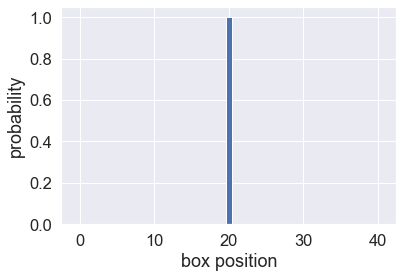

In [3]:
plt.bar(np.arange(n_boxes), p[:,0])
plt.xlabel("box position")
plt.ylabel("probability");

### Activity 4 / Start of the homework 

Using the Master Equations we specified above, integrate the $p(n,t)$ probability array.

In [4]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    p[-1,t] = p[-1,t-1] + k*dt*p[-2,t-1] - k*dt*p[-1,t-1]

## Problem 1 - Diffusion in a box

From the Master Equation numerical integration, plot the probability distribution of the particles at time step 0, 49, and 99. How does this time-lapse show diffusion?

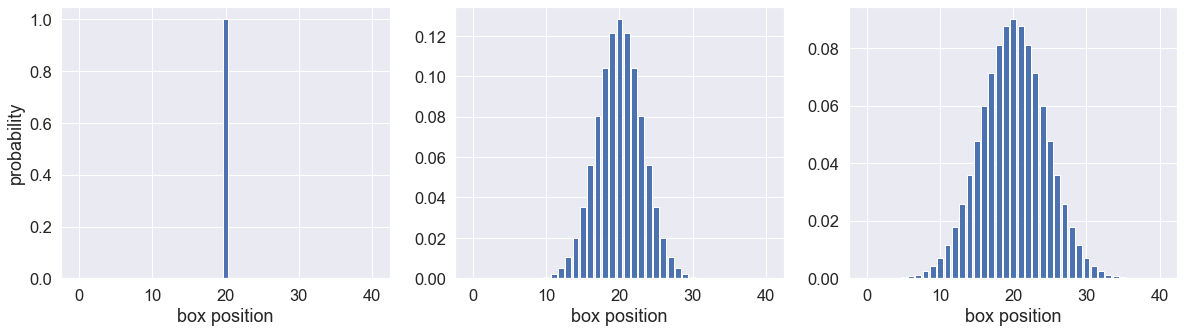

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].bar(np.arange(n_boxes), p[:,0])
ax[0].set_xlabel("box position")
ax[0].set_ylabel("probability");

ax[1].bar(np.arange(n_boxes), p[:,49])
ax[1].set_xlabel("box position")

ax[2].bar(np.arange(n_boxes), p[:,99])
ax[2].set_xlabel("box position");

We see diffusion has occurred, as the probability has spread out substantially over time.

## Problem 2 - Diffusion in a smaller box

Repeat the numerical integration and plotting with `n_boxes = 11`. Describe what you see and compare it to the plots in Problem 1.

In [6]:
# number of boxes
n_boxes = 11

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the middle box to have probability 1 at the initial time step 
p[n_center, 0] = 1

In [7]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    p[-1,t] = p[-1,t-1] + k*dt*p[-2,t-1] - k*dt*p[-1,t-1]

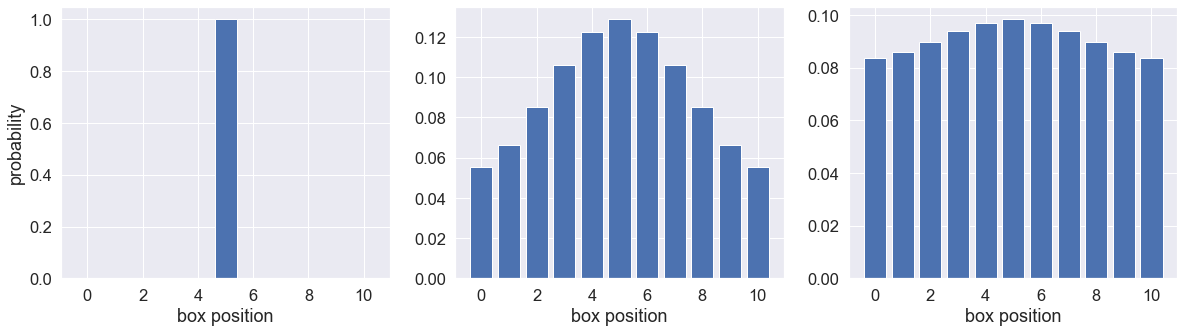

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].bar(np.arange(n_boxes), p[:,0])
ax[0].set_xlabel("box position")
ax[0].set_ylabel("probability");

ax[1].bar(np.arange(n_boxes), p[:,49])
ax[1].set_xlabel("box position")

ax[2].bar(np.arange(n_boxes), p[:,99])
ax[2].set_xlabel("box position");

We see that the probability is now much more uniform. In Problem 1, we had no amount of visible probability at the edges. But this time with a smaller box, we were able to hit the edges more often, resulting in the probability being nearly uniform. 

## Problem 3 - Setting up a gradient

[Bicoid](https://en.wikipedia.org/wiki/Homeotic_protein_bicoid) is a key gene in the early development of the fruit fly, Drosophila. The protein is initially only found on the anterior (head) side of the embryo and diffuses further down the embryo over time. This ultimately results in a gradient, with diminishing amounts of Bicoid as you go further along the embryo. To simulate this process of the Bicoid gradient being set up, take the following steps:

- Edit the initial probability array (back to `n_boxes = 41`) to represent this scenario with Bicoid, where initially 100% of the particle probability is in the left-most "box".
- Run the Master Equation integration for `n_steps = 500`.
- Plot the results at time step 0, 249, and 499.
- Describe what you see and explain how diffusion was able to set up a gradient.

In [9]:
# number of boxes
n_boxes = 41

# number of steps
n_steps = 500

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the left-most box to have probability 1 at the initial time step 
p[0, 0] = 1

In [10]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    p[-1,t] = p[-1,t-1] + k*dt*p[-2,t-1] - k*dt*p[-1,t-1]

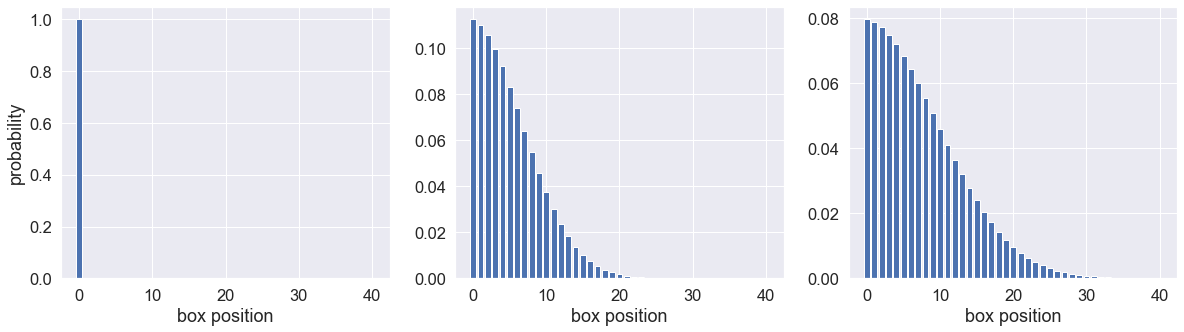

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].bar(np.arange(n_boxes), p[:,0])
ax[0].set_xlabel("box position")
ax[0].set_ylabel("probability");

ax[1].bar(np.arange(n_boxes), p[:,249])
ax[1].set_xlabel("box position")

ax[2].bar(np.arange(n_boxes), p[:,499])
ax[2].set_xlabel("box position");

By starting all of the probability in the left-most box, we are able to set up a gradient. It is very unlikely to end up in boxes far to the right. Box 30 for examples would result from getting "heads" 30 more times than "tails", which is very unlikely. It is much more likely to start near the initial position of Box 0 since we expect to get as many heads as tails on average. 

## Problem 4 - Fluorescence recovery after photobleaching (FRAP)

Having developed the numerical method of integrating the master equation, let's consider its application to the problem of fluorescence recovery after photobleaching (FRAP). In FRAP experiments, the fluorescently labeled molecules initially have a uniform distribution. Applying high intensity light, the fluorescent molecules in the desired region get photobleached, meaning that they no longer fluoresce. Over time, the fluorescent molecules that were outside the photobleached region will diffuse into it, recovering the uniform fluorescence distribution. By estimating the timescale of fluorescence recovery, experimentalists can determine the diffusion constant of fluorescently labeled molecules. To simulate FRAP, take the following steps: 

- Initailize the probability array such that all 41 boxes have the same amount of fluorescence to begin with.
- "Photobleach" the middle ten boxes, setting their probability to 0.
- Run the Master Equation integration for `n_step = 1000`.
- Plot the results at time step 0, 449, and 999.
- Describe what you see happening. Give a biological reason why fluorescence recovery might happen faster or slower in real life. Which parameter would you change to model this? 

In [12]:
# number of boxes
n_boxes = 41

# number of steps
n_steps = 1000

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the middle box to have probability 1 at the initial time step 
p[:, 0] = 1
p[15:26, 0] = 0

In [13]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    p[-1,t] = p[-1,t-1] + k*dt*p[-2,t-1] - k*dt*p[-1,t-1]

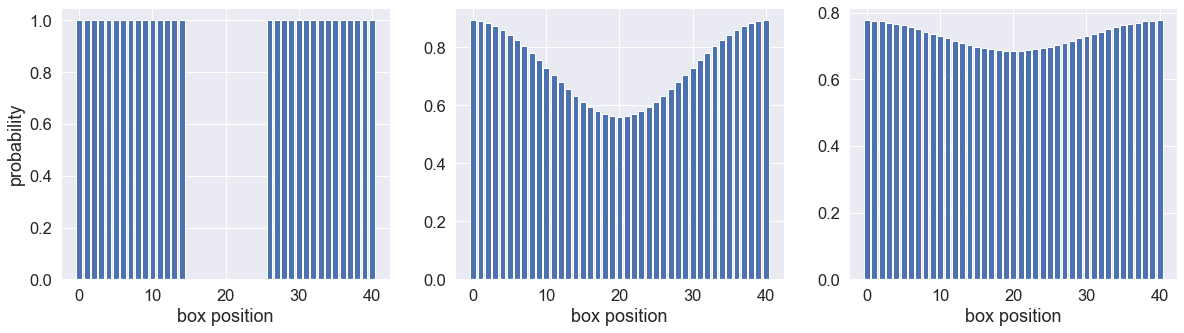

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].bar(np.arange(n_boxes), p[:,0])
ax[0].set_xlabel("box position")
ax[0].set_ylabel("probability");

ax[1].bar(np.arange(n_boxes), p[:,449])
ax[1].set_xlabel("box position")

ax[2].bar(np.arange(n_boxes), p[:,999])
ax[2].set_xlabel("box position");

We see the photobleached region filling back in over time. By the end, the probability is nearly uniform again. 

The size of a protein or the fluidity of the membrane could change the rate at which recovery occurs. We would model this by changing the "hopping rate" $k$.